# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [55]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use("dark_background")
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path ="/content/drive/MyDrive/NYC Taxi Trip Time Predication/NYC Taxi Data.csv"
nyc_df = pd.read_csv(path)

In [4]:
nyc_df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,30-01-2016 22:01,30-01-2016 22:09,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,17-06-2016 22:34,17-06-2016 22:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,21-05-2016 07:54,21-05-2016 08:20,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,27-05-2016 23:12,27-05-2016 23:16,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,10-03-2016 21:45,10-03-2016 22:05,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [5]:
nyc_df.shape

(1048575, 11)

In [6]:
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.534503e+00,1.664382e+00,-7.397342e+01,4.075094e+01,-7.397336e+01,4.075183e+01,9.621448e+02
std,4.988084e-01,1.314261e+00,4.280165e-02,3.381389e-02,4.274282e-02,3.645002e-02,5.853002e+03
min,1.000000e+00,0.000000e+00,-7.854740e+01,3.435970e+01,-7.981798e+01,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073738e+01,-7.399131e+01,4.073594e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075415e+01,-7.397973e+01,4.075455e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396731e+01,4.076836e+01,-7.396301e+01,4.076984e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.391176e+01,3.526282e+06


In [7]:
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df['dropoff_datetime'])

In [8]:
nyc_df['pickup_day']=nyc_df['pickup_datetime'].dt.day_name()
nyc_df['dropoff_day']=nyc_df['dropoff_datetime'].dt.day_name()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


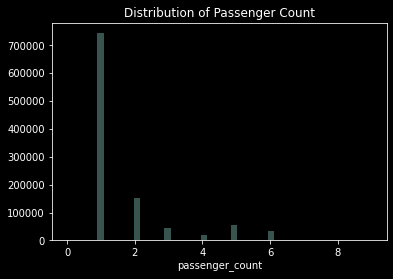

In [15]:
plt.style.use("dark_background")
sns.distplot(nyc_df['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

In [10]:
x=nyc_df['store_and_fwd_flag'].value_counts()
x

N    1042766
Y       5809
Name: store_and_fwd_flag, dtype: int64

Text(0.5, 1.0, 'Store and Forward Flag')

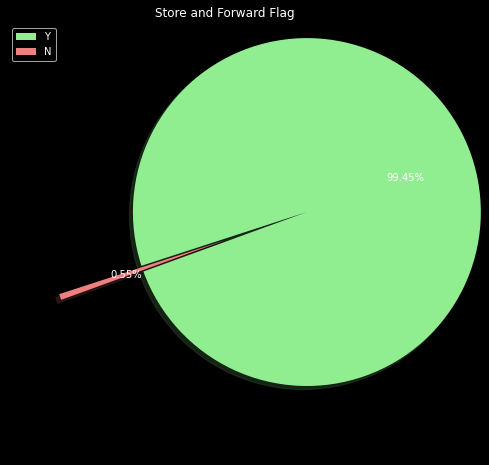

In [16]:
plt.style.use("dark_background")
plt.figure(figsize=(8,8))
plt.pie(x, colors=['lightgreen', 'lightcoral'], shadow=True, explode=[0.5,0], autopct='%1.2f%%', startangle=200)
plt.legend(labels=['Y','N'])
plt.title("Store and Forward Flag")

In [12]:
nyc_df['store_and_fwd_flag']=nyc_df['store_and_fwd_flag'].apply(lambda x : 0 if x=='N' else 1)

In [17]:
nyc_df['pickup_day'].value_counts()

Saturday     159756
Friday       153450
Thursday     152527
Wednesday    151238
Tuesday      146180
Sunday       145380
Monday       140044
Name: pickup_day, dtype: int64

In [18]:
nyc_df['dropoff_day'].value_counts()

Saturday     159871
Friday       153383
Thursday     152110
Wednesday    151005
Tuesday      146182
Sunday       146107
Monday       139917
Name: dropoff_day, dtype: int64

No handles with labels found to put in legend.


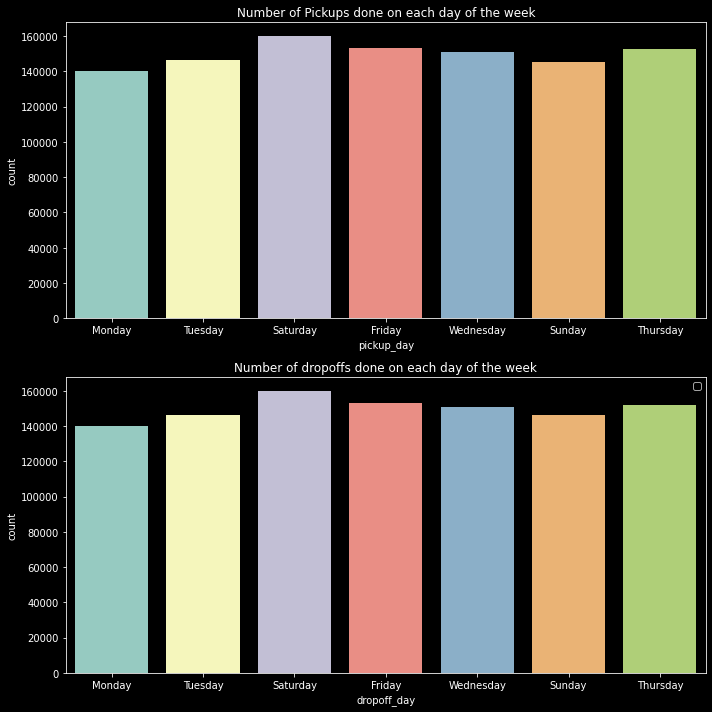

In [19]:
plt.style.use("dark_background")
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=nyc_df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=nyc_df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
nyc_df['pickup_timezone']=nyc_df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
nyc_df['dropoff_timezone']=nyc_df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

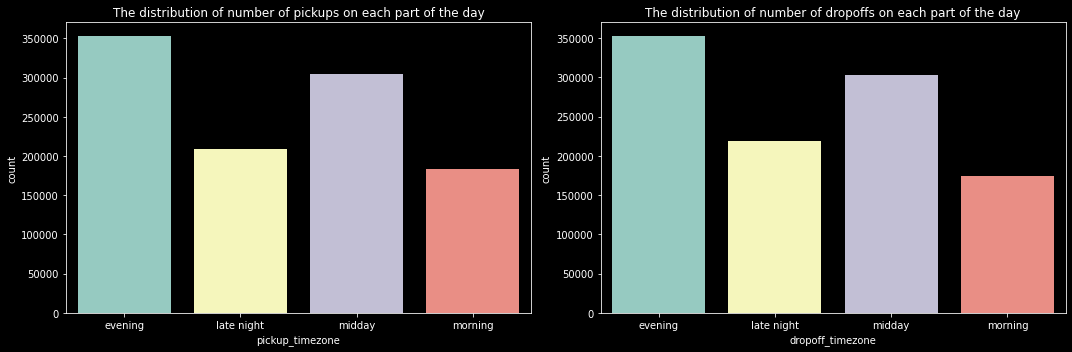

In [21]:
plt.style.use("dark_background")
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.countplot(x='pickup_timezone',data=nyc_df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=nyc_df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.tight_layout()

In [22]:
nyc_df['pickup_hour']=nyc_df['pickup_datetime'].dt.hour  #dt is required if you want to have adjust a column in your data frame 
nyc_df['dropoff_hour']=nyc_df['dropoff_datetime'].dt.hour

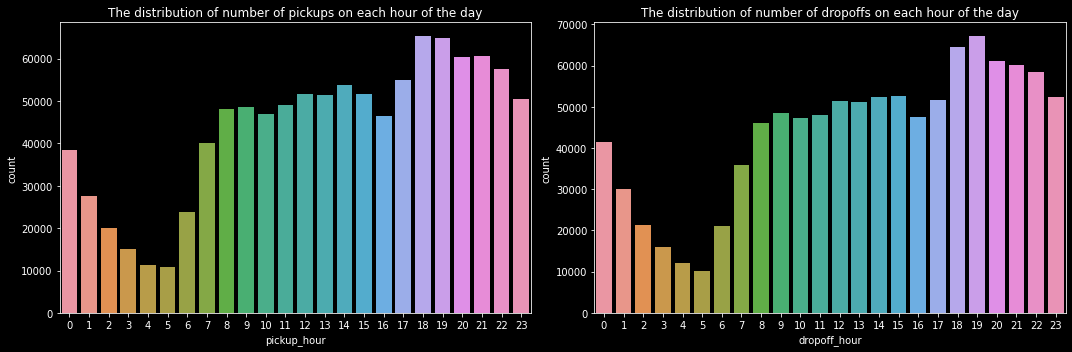

In [23]:
plt.style.use("dark_background")
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.countplot(x='pickup_hour',data=nyc_df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each hour of the day')
sns.countplot(x='dropoff_hour',data=nyc_df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each hour of the day')
plt.tight_layout()

In [30]:
nyc_df['pickup_month'] = nyc_df['pickup_datetime'].dt.month
nyc_df['pickup_date']=nyc_df['pickup_datetime'].dt.date

In [31]:
nyc_df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_timezone,dropoff_timezone,pickup_hour,dropoff_hour,pickup_month,pickup_date
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.964630,40.765602,0,455,Monday,Monday,evening,evening,17,17,3,2016-03-14
1,id2377394,1,2016-12-06 00:43:00,2016-12-06 00:54:00,1,-73.980415,40.738564,-73.999481,40.731152,0,663,Tuesday,Tuesday,late night,late night,0,0,12,2016-12-06
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,Tuesday,Tuesday,midday,midday,11,12,1,2016-01-19
3,id3504673,2,2016-06-04 19:32:00,2016-06-04 19:39:00,1,-74.010040,40.719971,-74.012268,40.706718,0,429,Saturday,Saturday,evening,evening,19,19,6,2016-06-04
4,id2181028,2,2016-03-26 13:30:00,2016-03-26 13:38:00,1,-73.973053,40.793209,-73.972923,40.782520,0,435,Saturday,Saturday,midday,midday,13,13,3,2016-03-26
5,id0801584,2,2016-01-30 22:01:00,2016-01-30 22:09:00,6,-73.982857,40.742195,-73.992081,40.749184,0,443,Saturday,Saturday,late night,late night,22,22,1,2016-01-30
6,id1813257,1,2016-06-17 22:34:00,2016-06-17 22:40:00,4,-73.969017,40.757839,-73.957405,40.765896,0,341,Friday,Friday,late night,late night,22,22,6,2016-06-17
7,id1324603,2,2016-05-21 07:54:00,2016-05-21 08:20:00,1,-73.969276,40.797779,-73.922470,40.760559,0,1551,Saturday,Saturday,morning,morning,7,8,5,2016-05-21
8,id1301050,1,2016-05-27 23:12:00,2016-05-27 23:16:00,1,-73.999481,40.738400,-73.985786,40.732815,0,255,Friday,Friday,late night,late night,23,23,5,2016-05-27
9,id0012891,2,2016-10-03 21:45:00,2016-10-03 22:05:00,1,-73.981049,40.744339,-73.973000,40.789989,0,1225,Monday,Monday,evening,late night,21,22,10,2016-10-03


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Overall Monthly trips')

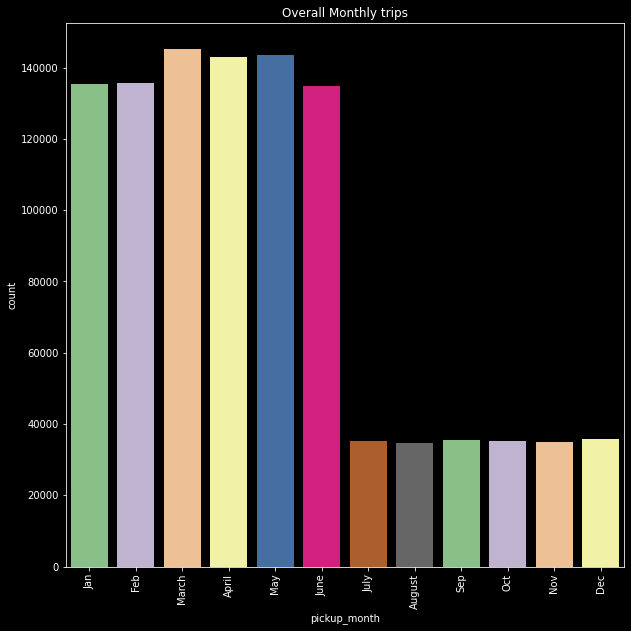

In [32]:
#monthly trips exploration
plt.style.use("dark_background")
plt.figure(figsize=(10,10))
sns.countplot(nyc_df['pickup_month'], palette='Accent')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], labels=['Jan','Feb','March','April','May','June','July','August','Sep','Oct','Nov','Dec'], rotation=90)
plt.title('Overall Monthly trips')

Text(0.5, 1.0, 'Correlation Plot')

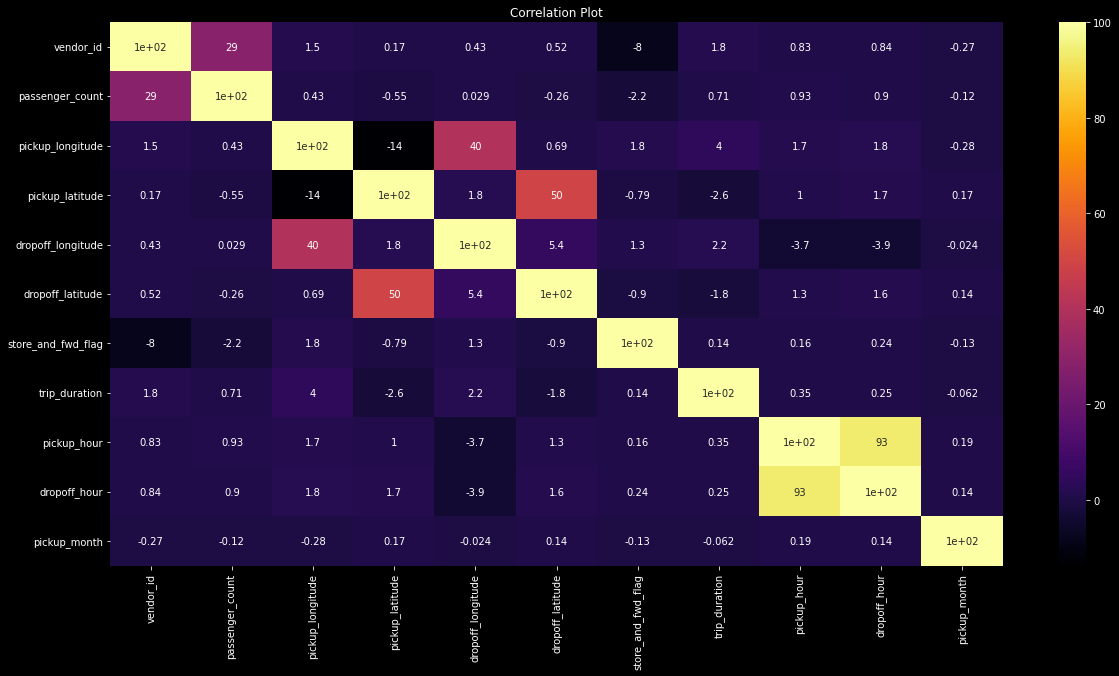

In [33]:
plt.style.use("dark_background")
plt.figure(figsize=(20,10))
sns.heatmap(nyc_df.corr()*100, annot=True, cmap='inferno')
plt.title('Correlation Plot')

In [34]:
nyc_df = nyc_df.drop(['id','pickup_datetime','pickup_date','dropoff_datetime'], axis=1)
nyc_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_timezone,dropoff_timezone,pickup_hour,dropoff_hour,pickup_month
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,Monday,Monday,evening,evening,17,17,3
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,Tuesday,Tuesday,late night,late night,0,0,12
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,Tuesday,Tuesday,midday,midday,11,12,1
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,Saturday,Saturday,evening,evening,19,19,6
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,Saturday,Saturday,midday,midday,13,13,3


In [35]:
X = nyc_df.drop(['trip_duration','pickup_day','dropoff_day','pickup_timezone','dropoff_timezone'], axis=1)
y = np.log(nyc_df['trip_duration'])

In [36]:

X.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,dropoff_hour,pickup_month
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,17,17,3
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0,0,12
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,11,12,1
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,19,19,6
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,13,13,3


In [37]:
from sklearn.preprocessing import StandardScaler

cols = X.columns

ss = StandardScaler()

new_df = ss.fit_transform(X)
new_df = pd.DataFrame(new_df, columns=cols)
new_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,dropoff_hour,pickup_month
0,0.933219,-0.505518,-0.204087,0.502596,0.204269,0.377718,-0.074638,0.529897,0.524148,-0.584700
1,-1.071559,-0.505518,-0.163446,-0.366076,-0.611098,-0.567426,-0.074638,-2.126210,-2.097566,2.474816
2,0.933219,-0.505518,-0.131005,0.384366,-0.748004,-1.145334,-0.074638,-0.407552,-0.246945,-1.264593
3,0.933219,-0.505518,-0.855591,-0.915935,-0.910257,-1.237745,-0.074638,0.842380,0.832585,0.435139
4,0.933219,-0.505518,0.008565,1.249992,0.010244,0.841866,-0.074638,-0.095069,-0.092726,-0.584700


In [38]:
X = new_df
y = np.log(nyc_df['trip_duration']).values

#Linear Regression

In [39]:
#split data in train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [40]:
from sklearn.linear_model import LinearRegression

est_lr = LinearRegression()
est_lr.fit(X_train, y_train)
lr_pred = est_lr.predict(X_test)
lr_pred

array([6.41630633, 6.61052288, 6.36296861, ..., 6.38651534, 6.43798157,
       6.38455862])

In [46]:
print ("Training Score : " , est_lr.score(X_train, y_train))

print ("Validation Score : ", est_lr.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_lr, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(lr_pred, y_test))


Training Score :  0.05952900605281264
Validation Score :  0.05443610200248061
Cross Validation Score :  0.05499443668126909
R2_Score :  -13.619816633863868


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Test VS Prediction')

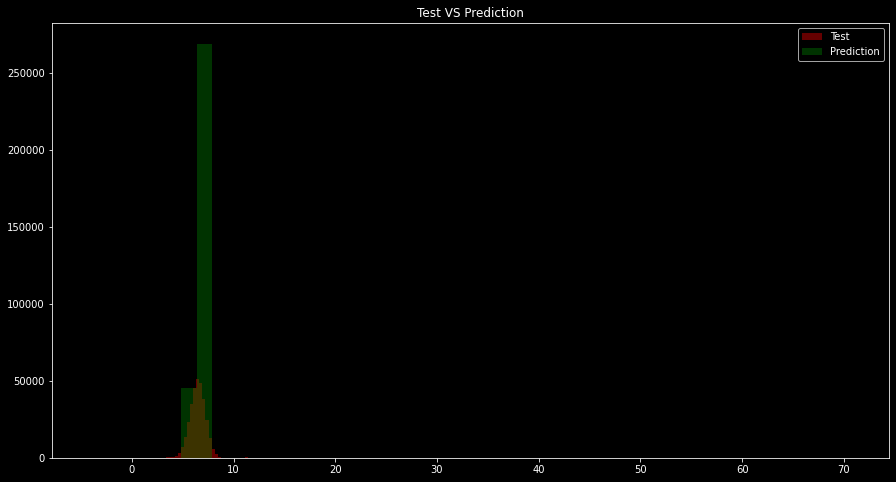

In [42]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="r", label="Test")

plt.subplot(1,1,1)
sns.distplot(lr_pred, kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

In [43]:
#null rmsle implementation
from sklearn.metrics import mean_squared_log_error
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())
print ("Null RMSLE : ", np.sqrt(mean_squared_log_error(y_test, y_null)))

Null RMSLE :  0.11512180600399516


#Decision Tree

In [44]:
#implementation of decision tree

from sklearn.tree import DecisionTreeRegressor

est_dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict(X_test)
dt_pred

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


array([6.15287829, 7.01074529, 6.69549987, ..., 5.94718585, 6.44416442,
       6.89160161])

In [47]:
#examining metrics

print ("Training Score : " , est_dt.score(X_train, y_train))

print ("Validation Score : ", est_dt.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(dt_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.46448168489943775
Validation Score :  0.4572601949846916


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: 

Cross Validation Score :  0.4540454189279215
R2_Score :  -0.16583191304878486
RMSLE :  0.08827629600398446


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Test VS Prediction')

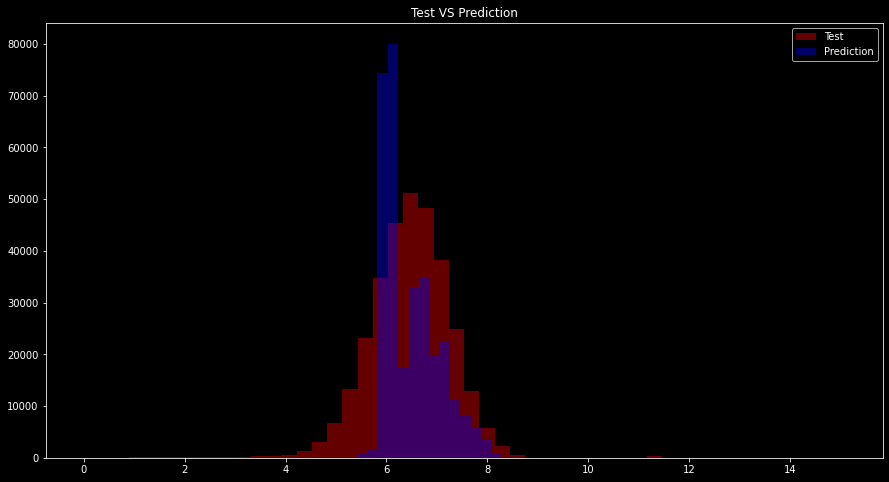

In [50]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="red", label="Test")

plt.subplot(1,1,1)
sns.distplot(dt_pred, kde=False, color="blue", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

In [56]:
#hyper parameter tuning

params = {'max_depth':[10,11,12,None], "min_samples_split":[2,3,4,5], 'max_features':[2,5,7,10]}

grid = GridSearchCV(est_dt, params, cv=5)
grid.fit(X_train, y_train)
grid_pred = grid.predict(X_test)
print (grid_pred)
grid.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: 

[6.09490102 7.21806868 6.76801414 ... 5.49539071 6.27908938 7.05160724]


{'max_depth': 12, 'max_features': 7, 'min_samples_split': 4}

In [58]:
print ("R2_Score after parameter tuning : ", r2_score(grid_pred, y_test))

print ("RMSLE after parameter tuning : ", np.sqrt(mean_squared_log_error(grid_pred, y_test)))

R2_Score after parameter tuning :  -0.06734316850724276
RMSLE after parameter tuning :  0.0875424750105521


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'Test VS Grid_Prediction')

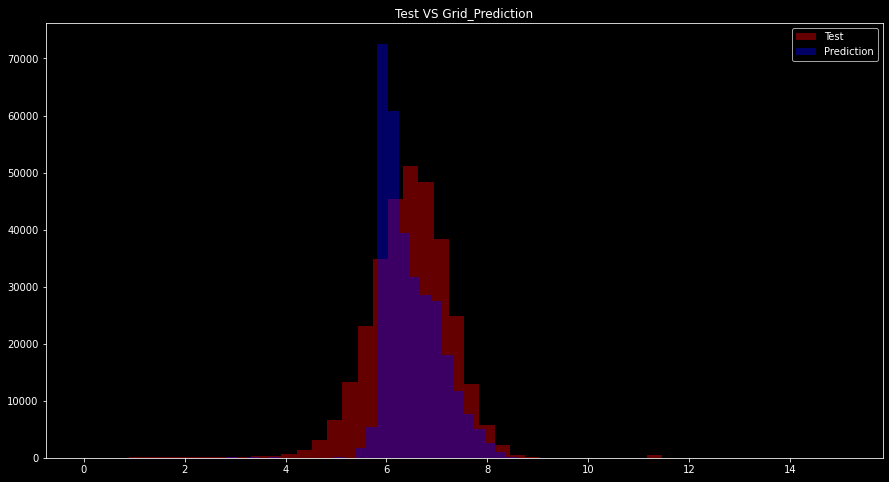

In [59]:

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="red", label="Test")

plt.subplot(1,1,1)
sns.distplot(grid_pred, kde=False, color="blue", label="Prediction")
plt.legend()
plt.title("Test VS Grid_Prediction")

In [60]:
#random forest implementation

from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(criterion="mse", n_estimators=5, max_depth=10)
est_rf.fit(X_train, y_train)
rf_pred = est_rf.predict(X_test)
rf_pred

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


array([6.16784072, 7.23136233, 6.70158015, ..., 5.95610762, 6.38551253,
       6.89678304])

In [61]:
#examining metrics 

print ("Training Score : " , est_rf.score(X_train, y_train))

print ("Validation Score : ", est_rf.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_rf, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(rf_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(rf_pred, y_test)))

Training Score :  0.47830831351745473
Validation Score :  0.4716128661707444


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: 

Cross Validation Score :  0.4690427793034827
R2_Score :  -0.18497133774273178
RMSLE :  0.08730829019781046


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Test VS Prediction')

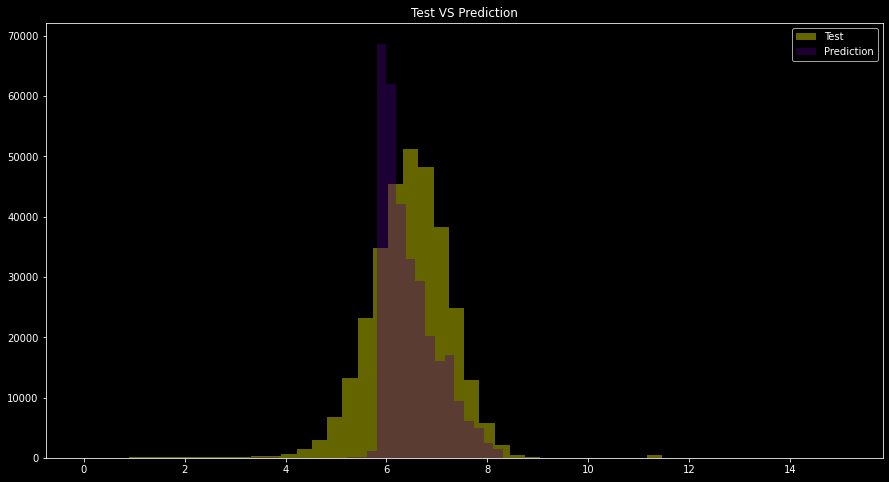

In [63]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="yellow", label="Test")

plt.subplot(1,1,1)
sns.distplot(rf_pred, kde=False, color="indigo", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

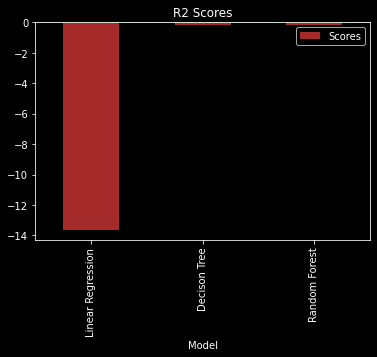

In [64]:
#r2 score plot for all 3 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(lr_pred, y_test), r2_score(dt_pred, y_test), r2_score(rf_pred, y_test)]), 'Model':np.array(['Linear Regression', 'Decison Tree', 'Random Forest'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")